# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [3]:
!pip -q install ./python

In [4]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [5]:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# set random seeds
# Seed
SEED=1211
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device info
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [8]:
# environment details
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
print('Size of state:', state_size)
print('Size of action:', action_size)
# number of agents in the environment
print('Number of agents:', len(env_info.agents))
# examine the state space 
print('States look like:', state)

Size of state: 37
Size of action: 4
Number of agents: 1
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]


### 3. Introduction
Prioritized DQN is one of the improvements over Double DQNs.It was first discussed on paper [Prioritized Experience Replay (PER)](https://arxiv.org/abs/1511.05952) which was introduced in 2015 by Tom Schaul. The basic idea is that some experiences may be more important than others for our training, but it might occur less frequently. Because we sample the batch randomly these rich experiences will rarely get selected or no chance to be selected. Hence, we add priority with each experience and sample based on priority.

#### 3.1 Revisting the Double DQN algorithm

DQN algorithm attempts to find a policy $\pi$ which maps a given state $s_t$ to an action at such that it maximizes the expected reward of the agent $\mathbb{E}_{\pi}\Big[ \sum_{t=0}^\infty r_t \Big]$ from some starting state $s_0$. DQN obtains $\pi$ implicitly by calculating a state-value function $Q_θ(s,a)$ parameterized by θ, which measures the goodness of the given state-action with respect to some behavioral policy.

To find an appropriate θ, which then determines the final policy $\pi$, DQN performs the following optimization:

<center>
$
{\rm minimize}_{\theta} \;\; \mathbb{E}_{(s_t,a_t,r_t,s_{t+1})\sim D}
\left[
\Big(r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a) - Q_\theta(s_t,a_t)\Big)^2
\right]
$
</center>


where $(s_t,a_t,r_t,s_{t+1})$ are batches of samples from the replay buffer $D$, which is designed to store the past N samples. In addition, $A$ represents the set of discrete actions, θ is the local network and $\theta^-$ represents the target network. Both networks use the same architecture, and we use $Q_θ(s,a)$ or $Q_{\theta^-}(s,a)
$ to denote which of the two is being applied to evaluate (s,a).

The target network starts off by getting matched to the current network, but remains frozen (usually for thousands of steps) before getting updated again to match the network. The process repeats throughout training, with the goal of increasing the stability of the targets $r_t + \gamma \max_{a \in \mathcal{A}}Q_{\theta^-}(s_{t+1},a)$.

#### 3.2 Temporal difference (or TD) error
The difference between the estimated reward at any given state and the actual reward received. The larger the error function, the larger the difference between the expected and actual reward.
TD Error for vanilla DQN:

<center>
$\delta_i = r_t + \gamma \max_{a \in \mathcal{A}} Q_{\theta^-}(s_{t+1},a) -
Q_\theta(s_t,a_t)$
</center>

and for Double-DQN:

<center>
$\delta_i = r_t + \gamma Q_{\theta^-}(s_{t+1},{\rm argmax}_{a \in \mathcal{A}}
Q_\theta(s_{t+1},a)) - Q_\theta(s_t,a_t)$
</center>

Given the magnitude of the TD error $| \delta_i |$. We can calculate the priority $p_i$ by adding $\epsilon$ to TD error magnitude.


<center>
$p_i = | \delta_i | + \epsilon$    
</center>

where $\epsilon$ is a small constant ensuring that the sample has some non-zero probability of being drawn.

But we can’t do greedy prioritization, because it will lead to always training the same experiences (that have big priority), and then we'll be over-fitting our agent. So, we will use stochastic prioritization, which generates the probability of being chosen for a replay:

<center>
$P(i) = \frac{p_i^a}{\sum_k p_k^a}$
</center>

Where:
- $p_i$ - Priority value
- $\sum_k p_k^a$ - Normalization by all priority values in Replay Buffer
- $𝑎$ - Hyperparameter used to reintroduce some randomness in the experience selection for the replay buffer (if a=0 pure randomness, if a=1 only selects the experience with the highest priorities)

Now, we can put this priority $P(i)$ in our replay buffer tuple $(s_{t},a_{t},r_{t},s_{t+1}, P(i))$. 

### Model
Fully connected NN layer with 1 hidden layer. 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

class DQNetwork(nn.Module):
    """ Deep Q-Network """
    
    def __init__(self, state_size, action_size, fc1_size=64, fc2_size=64):
        """Initialize parameters and fc model.
        Params
        ======
            state_size : Dimension of each state
            action_size : Dimension of each action
            seed : Random seed
            fc1_size : Number of nodes in first hidden layer
            fc2_size : Number of nodes in second hidden layer
        """
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Sum Tree

According to the paper, when we are using Proportional Prioriziation for $P(i)$ then we should use "sum-tree" data structure for storing a pair of transition and $P(i)$. SumTree helps us select some numbers randomly according to their probability.



In [10]:
import random
import numpy
from collections import deque

class SumTree:
    """ Story data with its priority in the tree """
    write = 0

    def __init__(self, capacity):
        """ We initialize the tree with all nodes = 0, and initialize the data with all values = 0
        Params
        ======
            capacity : for all priority values
        """
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

### 5. Prioritized Buffer

Since samples that have high priority are more likely to be selected for many time in our training in comparison to low priority experience. So, as a consequence, we will update our weights with only a small portion of experience that we consider to be interesting. To correct this we will use importance sampling weight where we adjust (or reduce). the weight of ofen seen samples.


<center>
$(\frac{1}{N} \times \frac{1}{P(i)})^b$
</center>

Where:
- 𝑁 - Replay Buffer Size
- 𝑃(𝑖) - Sampling probability



In [11]:
class PrioritizedBuffer:
    """ Samples the batch data according to priority """

    def __init__(self, max_size, alpha=0.6, beta=0.4):
        """ Initialize the sum_tree and hyperparameters alpha and beta
        Params
        ======
            max_size : for all priority values
        """
        self.sum_tree = SumTree(max_size)
        self.alpha = alpha
        self.beta = beta
        self.current_length = 0

    def push(self, state, action, reward, next_state, done):
        priority = 1.0 if self.current_length is 0 else self.sum_tree.tree.max()
        self.current_length = self.current_length + 1
        experience = (state, action, np.array([reward]), next_state, done)
        self.sum_tree.add(priority, experience)

    def sample(self, batch_size):
        batch_idx, batch, IS_weights = [], [], []
        segment = self.sum_tree.total() / batch_size
        p_sum = self.sum_tree.tree[0]

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            idx, p, data = self.sum_tree.get(s)

            batch_idx.append(idx)
            batch.append(data)
            prob = p / p_sum
            IS_weight = (self.sum_tree.total() * prob) ** (-self.beta)
            IS_weights.append(IS_weight)

        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        for transition in batch:
            state, action, reward, next_state, done = transition
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch), batch_idx, IS_weights

    def update_priority(self, idx, td_error):
        priority = td_error ** self.alpha
        self.sum_tree.update(idx, priority)

    def __len__(self):
        return self.current_length

### 6. Agent


In [12]:
class PrioritizedDQN:
    """ Prioritized DQN Agent """

    def __init__(self,state_size, action_size , learning_rate=3e-4, gamma=0.99, buffer_size=10000):
        """ Initialize the sum_tree and hyperparameters alpha and beta
        Params
        ======
            state_size : state size
            action_size : action size
            learning_rate: learning rate
            gamma:  discount factor
            buffer_size: replay buffer size
        """
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate

        self.replay_buffer = PrioritizedBuffer(buffer_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        
        self.model = DQNetwork(state_size, action_size).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.MSE_loss = nn.MSELoss()

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        self.model.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def _sample(self, batch_size):
        """ Get Samples from replay buffer

        Params
        ======
            batch_size : batch size
        
        """
        return self.replay_buffer.sample(batch_size)

    def _compute_TDerror(self, batch_size):
        transitions, idxs, IS_weights = self._sample(batch_size)
        states, actions, rewards, next_states, dones = transitions

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        IS_weights = torch.FloatTensor(IS_weights).to(self.device)

        curr_Q = self.model(states).gather(1, actions.unsqueeze(1))
        curr_Q = curr_Q.squeeze(1)
        next_Q = self.model(next_states)
        max_next_Q = torch.max(next_Q, 1)[0]
        expected_Q = rewards.squeeze(1) + self.gamma * max_next_Q

        td_errors = torch.pow(curr_Q - expected_Q, 2) * IS_weights

        return td_errors, idxs

    def update(self, batch_size):
        td_errors, idxs = self._compute_TDerror(batch_size)

        # update model
        td_errors_mean = td_errors.mean()
        self.optimizer.zero_grad()
        td_errors_mean.backward()
        self.optimizer.step()

        # update priorities
        for idx, td_error in zip(idxs, td_errors.cpu().detach().numpy()):
            self.replay_buffer.update_priority(idx, td_error)
            
    
    def print(self):
        num_parameters = sum([params.numel() for params in self.model.parameters() if params.requires_grad]);
        print(self.model)
        print(f"Number of parameters in model : {num_parameters}")

### 7. Initialize Agent

In [13]:
# Hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.99            # discount factor
LR = 5e-3               # learning rate 
BATCH_SIZE = 64         # minibatch size
max_t = 500
eps_start=1.0
eps_decay=.995
eps_min=0.05
n_episodes = 1000

agent = PrioritizedDQN(state_size, action_size)
agent.print()

DQNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)
Number of parameters in model : 6852


### 8. Train

In [14]:
def train(agent, n_episodes, max_t, eps_start, eps_min, eps_decay):

    scores = []                                               # list containing scores from each episode                 
    scores_window = deque(maxlen=100)                         # store only the last 100 scores
    eps = eps_start                                           # initialize epsilon (for epsilon-greedy policy)
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        state = env_info.vector_observations[0]               # get the initial state
        score = 0                                             # initialize the score

        for t in range(max_t):                                # run for maximum of max_t timesteps 
            action = agent.act(state, eps)                    # select the action
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]      # get the state
            reward = env_info.rewards[0]                      # get the reward
            done = env_info.local_done[0]                     # whether the episode is complete or not
            agent.replay_buffer.push(state, action, reward, next_state, done)
            score += reward

            if len(agent.replay_buffer) > BATCH_SIZE:
                agent.update(BATCH_SIZE)   

            if done or t == max_t-1:
                scores.append(score)
                break

            state = next_state

        scores_window.append(score)                # update the window of scores
        scores.append(score)                       # update the list of scores
        eps = max(eps_min, eps * eps_decay)        # modify epsilon
        average_score = np.mean(scores_window)
        print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {} \tAverage score: {: .2f}'.format(i_episode, average_score))            
            
    return scores

### 9. Start training

Episode 100 	Average score:  0.07
Episode 200 	Average score:  1.07
Episode 300 	Average score:  1.37
Episode 400 	Average score:  2.00
Episode 500 	Average score:  2.21
Episode 600 	Average score:  3.80
Episode 700 	Average score:  1.52
Episode 800 	Average score:  3.07
Episode 900 	Average score:  2.11
Episode 1000 	Average score:  2.14


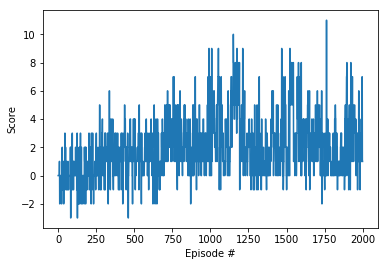

In [15]:
# train the model
scores = train(agent, n_episodes, max_t, eps_start, eps_min, eps_decay)
# save model
torch.save(agent.model.state_dict(), 'checkpoint/prioritize_dqn.pth')

import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('results/prioritize_dqn_result.png', bbox_inches='tight')
plt.show()

### 10. Model in action

In [20]:
agent.model.load_state_dict(torch.load('checkpoint/prioritize_dqn.pth'))
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [18]:
env.close()